<a href="https://colab.research.google.com/github/phanhuy0410/LuanVan/blob/main/Forensic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tarfile
from pathlib import Path

BASE_DIR = Path("/content/drive/MyDrive/DARPA_TC")
OUTPUT_DIR = BASE_DIR / "E3_extracted"
OUTPUT_DIR.mkdir(exist_ok=True)

tar_files = [
    "ta1-theia-e3-official-1r.json.tar.gz",
    "ta1-theia-e3-official-3.json.tar.gz",
    "ta1-theia-e3-official-5m.json.tar.gz",
    "ta1-theia-e3-official-6r.json.tar.gz"
]

for tar_name in tar_files:
    scenario = tar_name.split("-")[-1].replace(".json.tar.gz", "")
    extract_dir = OUTPUT_DIR / scenario
    extract_dir.mkdir(exist_ok=True)

    tar_path = BASE_DIR / tar_name
    print(f"Extracting {tar_name} → {extract_dir}")

    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)

print("✅ Done extracting all 4 files")



Extracting ta1-theia-e3-official-1r.json.tar.gz → /content/drive/MyDrive/DARPA_TC/E3_extracted/1r


/tmp/ipython-input-1998673097.py:24: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_dir)


Extracting ta1-theia-e3-official-3.json.tar.gz → /content/drive/MyDrive/DARPA_TC/E3_extracted/3
Extracting ta1-theia-e3-official-5m.json.tar.gz → /content/drive/MyDrive/DARPA_TC/E3_extracted/5m
Extracting ta1-theia-e3-official-6r.json.tar.gz → /content/drive/MyDrive/DARPA_TC/E3_extracted/6r
✅ Done extracting all 4 files


In [ ]:
from pathlib import Path
import orjson

def get_datum(record):
    return record.get("datum", {})
f = next(Path("/content/drive/MyDrive/DARPA_TC/E3_extracted").glob("**/*.json*"))
with open(f, "rb") as fh:
    for i in range(30):
        rec = orjson.loads(fh.readline())
        print(list(get_datum(rec).keys())[0])


com.bbn.tc.schema.avro.cdm18.Host
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Principal
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.Subject
com.bbn.tc.schema.avro.cdm18.MemoryObject
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.FileObject
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.FileObject
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.FileObject
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.FileObject
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Event
com.bbn.tc.schema.avro.cdm18.Event
com.bbn

In [ ]:
# =========================================================
# DARPA TC THEIA E3 - OPTIMIZED PIPELINE
# =========================================================

import orjson
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import traceback

# =========================
# CONFIG
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
LABEL_FILE = Path("/content/drive/MyDrive/DARPA_TC/multiclass.json")

OUTPUT_DIR = Path("/content/drive/MyDrive/Result_Dataset")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PARQUET = OUTPUT_DIR / "darpaTC_theia_labeled.parquet"

BATCH_SIZE = 300_000   # tăng batch

# =========================
# LOAD LABEL SPEC
# =========================
with open(LABEL_FILE, "rb") as f:
    label_spec = orjson.loads(f.read())

LABEL_MAPPING = {
    int(k): v["name"]
    for k, v in label_spec["label_definition"].items()
}
INDICATORS = label_spec["indicators"]

# =========================
# PRECOMPUTE LABEL LOOKUPS (O(1))
# =========================
PROC_LABEL = {}
PATH_LABEL = {}
IP_LABEL   = {}

for ind in INDICATORS:
    lbl = (
        ind.get("default_label")
        or ind.get("label")
        or ind.get("label_id")
    )

    if isinstance(lbl, str):
        lbl = next(
            (k for k, v in LABEL_MAPPING.items() if v == lbl),
            0
        )

    lbl = int(lbl) if lbl is not None else 0

    if ind["type"] == "process_name":
        PROC_LABEL[ind["value"]] = lbl
    elif ind["type"] == "file_path":
        PATH_LABEL[ind["value"]] = lbl
    elif ind["type"] == "ip":
        IP_LABEL[ind["value"]] = lbl

# =========================
# GLOBAL LOOKUP TABLES
# =========================
principal_info = {}
subject_info   = {}
object_info    = {}

# =========================
# HELPERS
# =========================
def get_datum(record):
    if "datum" in record:
        return record["datum"]
    if "root" in record:
        return record["root"].get("datum", {})
    return {}

def find_by_suffix(datum, suffix):
    for k, v in datum.items():
        if k.endswith(suffix):
            return v
    return None

# =========================
# PASS 1: METADATA SCAN
# =========================
def parse_metadata(rec):
    datum = get_datum(rec)
    if not datum: return

    # --- 1. PRINCIPAL (USER) ---
    p = find_by_suffix(datum, ".Principal")
    if p:
        uid = p.get("uid") or p.get("userId")
        principal_info[p["uuid"]] = {
            "uid": uid,
            "username": p.get("username", f"user_{uid}")
        }
        return

    # --- 2. SUBJECT (PROCESS) [FIX QUAN TRỌNG] ---
    s = find_by_suffix(datum, ".Subject")
    if s:
        proc_name = None

        # ƯU TIÊN 1: Lấy từ properties['map']['path']
        props = s.get("properties")
        if isinstance(props, dict):
            pmap = props.get("map", {})
            if isinstance(pmap, dict):
                # Lấy path (ví dụ: '/usr/bin/firefox' hoặc 'swapper/0')
                raw_path = pmap.get("path")

                if raw_path and isinstance(raw_path, str) and raw_path != "N/A":
                    # Logic xử lý đường dẫn:
                    if raw_path.startswith("/"):
                        # Là đường dẫn file (VD: /usr/bin/firefox) -> Lấy tên cuối
                        proc_name = raw_path.split("/")[-1]
                    else:
                        # Là tên kernel thread (VD: kthreadd) hoặc dạng swapper/0
                        # Giữ nguyên để không bị mất thông tin (VD: không bị biến thành "0")
                        proc_name = raw_path

        # ƯU TIÊN 2: Lấy từ cmdLine (nếu properties thất bại)
        if not proc_name:
            cmd = s.get("cmdLine")
            # Xử lý wrapper {'string': '...'} của Avro
            if isinstance(cmd, dict):
                cmd = cmd.get("string")

            if cmd and isinstance(cmd, str) and cmd != "N/A":
                # Lấy token đầu tiên (bỏ tham số), rồi lấy tên file
                # VD: "/bin/bash -c ..." -> "/bin/bash" -> "bash"
                first_token = cmd.split(" ")[0]
                proc_name = first_token.split("/")[-1]

        # Fallback cuối cùng
        if not proc_name:
            proc_name = "unknown"

        # Lưu Subject Info
        p_uuid = s.get("principal")
        if isinstance(p_uuid, dict):
            p_uuid = p_uuid.get("uuid")

        subject_info[s["uuid"]] = {
            "principal_uuid": p_uuid,
            "proc_name": proc_name.lower()
        }
        return

    # --- 3. FILE OBJECT ---
    fobj = find_by_suffix(datum, ".FileObject")
    if fobj:
        props = fobj.get("properties", {})
        if isinstance(props, dict):
            path = props.get("map", {}).get("path")
            if path:
                object_info[fobj["uuid"]] = {
                    "path": path,
                    "type": "FILE"
                }
        return

    # --- 4. NETFLOW OBJECT ---
    nobj = find_by_suffix(datum, ".NetFlowObject")
    if nobj:
        ip = nobj.get("remoteAddress")
        if ip:
            object_info[nobj["uuid"]] = {
                "ip": ip,
                "type": "NETFLOW"
            }

# =========================
# LABEL MATCHING (FAST)
# =========================
def match_label(proc, path, ip):
    return max(
        PROC_LABEL.get(proc, 0),
        PATH_LABEL.get(path, 0),
        IP_LABEL.get(ip, 0)
    )

# =========================
# EVENT PARSER
# =========================
def parse_event(rec, scenario):
    datum = get_datum(rec)
    evt = find_by_suffix(datum, ".Event")
    if not evt:
        return None

    subj = evt.get("subject")
    obj  = evt.get("object")

    subj_uuid = subj.get("uuid") if isinstance(subj, dict) else subj
    obj_uuid  = obj.get("uuid")  if isinstance(obj, dict)  else obj

    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")
    principal_uuid = s_info.get("principal_uuid")

    u_info = principal_info.get(principal_uuid, {})

    o_info = object_info.get(obj_uuid, {})
    obj_path = o_info.get("path")
    obj_ip   = o_info.get("ip")
    obj_type = o_info.get("type", "UNKNOWN")

    label_id = match_label(proc_name, obj_path, obj_ip)

    return {
        "timestamp": evt.get("timestampNanos", 0) // 1_000_000_000,
        "operation": evt.get("type"),
        "proc_name": proc_name,
        "user_uid": u_info.get("uid"),
        "username": u_info.get("username"),
        "obj_type": obj_type,
        "obj_path": obj_path,
        "obj_ip": obj_ip,
        "label_id": label_id,
        "label_name": LABEL_MAPPING.get(str(label_id), "Benign"),
        "scenario": scenario
    }

# =========================
# COLLECT FILES
# =========================
files = sorted([
    p for p in DATA_DIR.glob("**/*.json*")
    if not p.name.endswith(".tar.gz")
])

print(f"📂 Found {len(files)} files")

# =========================
# RUN PASS 1
# =========================
print("🔍 PASS 1: Metadata scan")
print("🔍 PASS 1: Metadata scan")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try:
                parse_metadata(orjson.loads(line))
            except Exception:
                # In lỗi ra để debug, thay vì nuốt lỗi
                traceback.print_exc()
                break # Dừng lại để sửa lỗi ngay

print(f"📊 Metadata: {len(principal_info)} users | "
      f"{len(subject_info)} processes | {len(object_info)} objects")


📂 Found 25 files
🔍 PASS 1: Metadata scan
🔍 PASS 1: Metadata scan


100%|██████████| 25/25 [23:46<00:00, 57.05s/it]

📊 Metadata: 23 users | 279369 processes | 186100 objects


In [ ]:
import pandas as pd
pd.Series(
    [v["proc_name"] for v in subject_info.values()]
).value_counts().head(10)

firefox            106554
bash                54335
dash                39701
stat                13207
postgres            10808
apt-config           9304
python2.7            7447
128.55.12.111-m      6381
pulseaudio           5655
thunderbird          5586
Name: count, dtype: int64

In [ ]:
# =========================
# RUN PASS 2 + WRITE PARQUET
# =========================
print("🧠 PASS 2: Event parsing")
writer = None
buffer = []

for f in files:
    scenario = f.parent.name
    with open(f, "rb") as fh:
        for line in fh:
            try:
                row = parse_event(orjson.loads(line), scenario)
                if row:
                    buffer.append(row)
            except:
                continue

            if len(buffer) >= BATCH_SIZE:
                table = pa.Table.from_pylist(buffer)
                if writer is None:
                    writer = pq.ParquetWriter(
                        OUTPUT_PARQUET, table.schema, compression="snappy"
                    )
                writer.write_table(table)
                buffer.clear()

# flush
if buffer:
    table = pa.Table.from_pylist(buffer)
    if writer is None:
        writer = pq.ParquetWriter(
            OUTPUT_PARQUET, table.schema, compression="snappy"
        )
    writer.write_table(table)

if writer:
    writer.close()

print("✅ DONE:", OUTPUT_PARQUET)
print("Exists?", OUTPUT_PARQUET.exists())

🧠 PASS 2: Event parsing
✅ DONE: /content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet
Exists? True


In [ ]:
import orjson
import pandas as pd
import gc
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# =========================
# 1. CẤU HÌNH & LOAD GROUND TRUTH
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
LABEL_FILE = Path("/content/drive/MyDrive/DARPA_TC/multiclass.json")

OUTPUT_DIR = Path("/content/drive/MyDrive/Result_Dataset")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PARQUET = OUTPUT_DIR / "darpaTC_theia_labeled.parquet"

BATCH_SIZE = 1_000_000

# Load nhãn từ file JSON Ground Truth
import json
with open(LABEL_FILE, "rb") as f:
    gt_data = json.load(f)

# =========================
# CẤU HÌNH NHÃN CHI TIẾT (REPLACE THIS SECTION)
# =========================

# Định nghĩa tên lớp
CLASS_NAMES = {
    0: "Benign",
    1: "Initial Access",      # T1190, T1566 (Phishing, Exploit)
    2: "Persistence",         # T1105 (File Drop, Browser Ext)
    3: "Privilege Escalation",# T1068 (Sudo, Setuid execution)
    4: "C2 & Exfiltration"    # T1041, T1071 (Connect C2)
}

# Cấu hình Indicators (Dựa trên PDF Ground Truth THEIA E3)
GT_CONFIG = {
    "ip": {
        # Initial Access IPs
        "104.228.117.212": 1, # Exploit Server (gatech.edu) [cite: 310]
        "208.75.117.3": 1,    # Phishing Site (nasa.ng) [cite: 1468]
        "208.75.117.2": 1,    # Phishing Site (foo1.com) [cite: 1469]

        # C2 IPs
        "141.43.176.203": 4,  # Drakon C2 [cite: 310]
        "146.153.68.151": 4,  # Drakon C2 [cite: 306]
        "161.116.88.72": 4,   # Profile C2 [cite: 304]
        "149.52.198.23": 4,   # Micro APT C2 [cite: 830]
    },
    "process": {
        # Initial Access
        "tcexec": 1,          # Malicious Attachment [cite: 1573]

        # Persistence / Execution names
        "gtcache": 2,         # Renamed Drakon

        # Privilege Escalation Tools
        "clean": 3,           # Dropped binary run as root [cite: 331]
        "profile": 3,         # Dropped binary run as root [cite: 332]

        # C2 Tools
        "microapt": 4,        # Network Scanner/C2 [cite: 785]
        "mail": 4             # Renamed MicroAPT [cite: 811]
    },
    "file": {
        # Persistence Files (File Drop)
        "/var/log/xdev": 2,       #[cite: 296]
        "/var/log/wdev": 2,       #[cite: 807]
        "/tmp/memtrace.so": 2,    #[cite: 809]
        "hJauWI01": 2,            # Malicious Ext File [cite: 759]
        "/home/admin/clean": 3,   # Tool leo thang [cite: 369]
        "/home/admin/profile": 3  # Tool leo thang [cite: 327]
    }
}

GT_IPS = GT_CONFIG["ip"]          # {'104.228...': 1, ...}
GT_PROCS = GT_CONFIG["process"]   # {'tcexec': 1, ...}
GT_FILES = GT_CONFIG["file"]      # {'/var/log/xdev': 2, ...}

print(f"🎯 Ground Truth đã nạp: {len(GT_IPS)} IPs, {len(GT_PROCS)} Procs, {len(GT_FILES)} Files.")

# =========================
# 2. GLOBAL LOOKUP TABLES
# =========================
principal_info = {}       # User UUID -> Username
subject_info = {}         # Subject UUID -> Proc Name
object_info = {}          # Object UUID -> {ip, path, type}

# =========================
# 3. HÀM XỬ LÝ DỮ LIỆU
# =========================
def get_datum(record):
    return record.get("datum") or record.get("root", {}).get("datum", {})

def parse_metadata(rec):
    datum = get_datum(rec)
    if not datum: return

    # --- A. XỬ LÝ PRINCIPAL (USER) ---
    for k, v in datum.items():
        if k.endswith(".Principal"):
            uid = v.get("uid") or v.get("userId")
            principal_info[v["uuid"]] = {
                "username": v.get("username", f"user_{uid}"),
                "uid": uid
            }
            return

        # --- B. XỬ LÝ SUBJECT (PROCESS) ---
        if k.endswith(".Subject"):
            # Logic lấy tên Process đã fix từ bài trước
            proc_name = "unknown"
            props = v.get("properties", {})
            if isinstance(props, dict):
                pmap = props.get("map", {})
                raw_path = pmap.get("path") or pmap.get("name")
                if raw_path and raw_path != "N/A":
                    proc_name = raw_path.split("/")[-1]

            if proc_name == "unknown":
                cmd = v.get("cmdLine")
                if isinstance(cmd, dict): cmd = cmd.get("string") # Xử lý wrapper
                if cmd and cmd != "N/A":
                    proc_name = cmd.split(" ")[0].split("/")[-1]

            subject_info[v["uuid"]] = {
                "proc_name": proc_name,
                "principal": v.get("principal", {}).get("uuid") if isinstance(v.get("principal"), dict) else v.get("principal")
            }
            return

        # --- C. XỬ LÝ NETFLOW (IP) - ĐÃ FIX THEO LOG BẠN GỬI ---
        if k.endswith(".NetFlowObject"):
            ip = v.get("remoteAddress")

            # Lọc bỏ giá trị rác
            if ip and ip not in ["NA", "NETLINK", "0.0.0.0", ""]:
                object_info[v["uuid"]] = {"ip": ip, "type": "NETFLOW"}
            return

        # --- D. XỬ LÝ FILE OBJECT ---
        if k.endswith(".FileObject"):
            props = v.get("properties", {})
            if isinstance(props, dict):
                path = props.get("map", {}).get("path")
                if path:
                    object_info[v["uuid"]] = {"path": path, "type": "FILE"}
            return

def get_label_id(proc_name, obj_ip, obj_path):
    # 1. IP CHECK (Ưu tiên cao nhất)
    # Thêm điều kiện != "NA" để tránh xử lý rác
    if obj_ip and obj_ip not in ["NA", "0.0.0.0"]:
        clean_ip = obj_ip.split(":")[0]
        if clean_ip in GT_IPS:
            return GT_IPS[clean_ip]

    # 2. PROCESS NAME CHECK
    # proc_name có thể là "unknown", check nhanh
    if proc_name and proc_name in GT_PROCS:
        return GT_PROCS[proc_name]

    # 3. FILE PATH CHECK
    if obj_path:
        # Check nhanh (Exact Match) - O(1)
        if obj_path in GT_FILES:
            return GT_FILES[obj_path]

        # Check chậm (Filename Match) - O(N)
        # Chỉ chạy nếu check nhanh thất bại
        fname = obj_path.split("/")[-1]

        # Mẹo: Nếu tên file quá ngắn hoặc phổ biến thì bỏ qua để tránh nhận nhầm
        if len(fname) > 3:
            for k, v in GT_FILES.items():
                # Logic của bạn: Nếu GT là "/var/log/xdev" và Log là "xdev" -> Match
                if k.endswith(fname):
                    return v

    return 0 # Mặc định là Benign

def parse_event(rec, scenario_name):
    datum = get_datum(rec)
    evt = None
    for k, v in datum.items():
        if k.endswith(".Event"):
            evt = v
            break
    if not evt: return None

    # Lấy UUID
    subj_uuid = evt.get("subject", {}).get("uuid") if isinstance(evt.get("subject"), dict) else evt.get("subject")
    obj_uuid = evt.get("object", {}).get("uuid") if isinstance(evt.get("object"), dict) else evt.get("object")

    # Tra cứu thông tin
    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")

    # Tra cứu User
    p_uuid = s_info.get("principal")
    u_info = principal_info.get(p_uuid, {})
    username = u_info.get("username", "unknown")

    # Tra cứu Object
    o_info = object_info.get(obj_uuid, {})
    obj_ip = o_info.get("ip")
    obj_path = o_info.get("path")
    obj_type = o_info.get("type", "UNKNOWN")

    # Gán nhãn
    label_id = get_label_id(proc_name, obj_ip, obj_path)

    # Ánh xạ sang tên (để con người dễ đọc)
    label_name = CLASS_NAMES.get(label_id, "Benign")

    # *** IN NÓNG NẾU PHÁT HIỆN TẤN CÔNG ***
    if label_id > 0:
        print(f"🚨 PHÁT HIỆN: {proc_name} -> {obj_ip or obj_path} | {label_name}")

    return {
        "timestamp": evt.get("timestampNanos", 0),
        "proc_name": proc_name,
        "username": username,
        "obj_ip": obj_ip,
        "obj_path": obj_path,
        "obj_type": obj_type,
        "label_id": label_id,
        "label_name": label_name,
        "scenario": scenario_name
    }

# =========================
# 4. CHẠY CHƯƠNG TRÌNH (MAIN)
# =========================
files = sorted([p for p in DATA_DIR.glob("**/*.json*") if not p.name.endswith(".tar.gz")])

print(f"📂 Tìm thấy {len(files)} files JSON.")

# --- PASS 1: METADATA ---
print("\n🔍 PASS 1: Đọc Metadata (Xây dựng bản đồ UUID)...")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try:
                parse_metadata(orjson.loads(line))
            except: pass

print(f"✅ Metadata Stats: {len(principal_info)} Users | {len(subject_info)} Procs | {len(object_info)} Objects")

# --- PASS 2: EVENTS ---
print("\n🧠 PASS 2: Xử lý Sự kiện & Gán nhãn...")
writer = None
buffer = []

for f in files:
    scenario = f.parent.name
    with open(f, "rb") as fh:
        for line in tqdm(fh, desc=f.name, leave=False):
            try:
                row = parse_event(orjson.loads(line), scenario)
                if row:
                    buffer.append(row)
            except: pass

            if len(buffer) >= BATCH_SIZE:
                table = pa.Table.from_pylist(buffer)
                if writer is None:
                    writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
                writer.write_table(table)
                buffer.clear()
        gc.collect()

# Flush cuối cùng
if buffer:
    table = pa.Table.from_pylist(buffer)
    if writer is None:
        writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
    writer.write_table(table)
if writer: writer.close()

print(f"\n🎉 XONG! Kết quả lưu tại: {OUTPUT_PARQUET}")

🎯 Ground Truth đã nạp: 7 IPs, 6 Procs, 6 Files.
📂 Tìm thấy 25 files JSON.

🔍 PASS 1: Đọc Metadata (Xây dựng bản đồ UUID)...


100%|██████████| 25/25 [25:39<00:00, 61.56s/it]


✅ Metadata Stats: 23 Users | 279369 Procs | 156944 Objects

🧠 PASS 2: Xử lý Sự kiện & Gán nhãn...



🎉 XONG! Kết quả lưu tại: /content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet


In [ ]:
import pyarrow.parquet as pq
from collections import Counter

PARQUET_FILE = "/content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet"

pf = pq.ParquetFile(PARQUET_FILE)

label_counter = Counter()

for batch in pf.iter_batches(
    batch_size=500_000,
    columns=["label_name"]  # hoặc "label_name"
):
    df = batch.to_pandas()
    label_counter.update(df["label_name"].value_counts().to_dict())

print("📊 PHÂN BỐ NHÃN:")
for k, v in label_counter.items():
    print(f"{k:25s} {v:,}")



📊 PHÂN BỐ NHÃN:
Benign                    106,044,692


In [ ]:
import orjson
from pathlib import Path
from collections import Counter
from tqdm import tqdm

# === CẤU HÌNH ===
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
# QUAN TRỌNG: Hãy thử đổi file nếu file đầu tiên không có gì
# Ví dụ: thử file chứa số '3' hoặc '5m' nếu '1r' sạch trơn
files = sorted([p for p in DATA_DIR.glob("**/*.json*") if not p.name.endswith(".tar.gz")])

# Chọn file để soi (Bạn có thể đổi index [0] thành [1], [2] để soi file khác)
target_file = files[11]

print(f"🕵️ Đang soi file: {target_file.name}")

# Bộ đếm tần suất
found_ips = Counter()
found_procs = Counter()

# Các giá trị Độc hại cần tìm (Mục tiêu)
TARGET_IPS = {"104.228.117.212", "141.43.176.203", "161.116.88.72", "149.52.198.23", "208.75.117.3"}
TARGET_PROCS = {"clean", "profile", "microapt", "mail", "gtcache", "tcexec"}

def scan_file():
    with open(target_file, "rb") as fh:
        # Quét 500,000 dòng đầu tiên là đủ để thấy xu hướng
        for i, line in enumerate(tqdm(fh, desc="Scanning", total=5000000)):
            if i > 5000000: break

            try:
                rec = orjson.loads(line)
                datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
                if not datum: continue

                # 1. Thu thập Tên Process
                for k, v in datum.items():
                    if k.endswith(".Subject"):
                        proc_name = "unknown"
                        # Logic trích xuất
                        props = v.get("properties", {})
                        if isinstance(props, dict):
                            pmap = props.get("map", {})
                            raw_path = pmap.get("path") or pmap.get("name")
                            if raw_path and raw_path != "N/A":
                                proc_name = raw_path.split("/")[-1]

                        if proc_name == "unknown":
                            cmd = v.get("cmdLine")
                            if isinstance(cmd, dict): cmd = cmd.get("string")
                            if cmd and cmd != "N/A":
                                proc_name = cmd.split(" ")[0].split("/")[-1]

                        found_procs[proc_name] += 1

                # 2. Thu thập IP
                for k, v in datum.items():
                    if k.endswith(".NetFlowObject"):
                        ip = v.get("remoteAddress")
                        # Lấy cả IP trong properties nếu bên ngoài là NA
                        if not ip or ip == "NA":
                            props = v.get("properties", {})
                            if isinstance(props, dict):
                                ip = props.get("map", {}).get("remoteAddress")

                        if ip and ip not in ["NA", "NETLINK", "0.0.0.0", ""]:
                            found_ips[ip] += 1

            except: continue

    # --- IN BÁO CÁO ---
    print("\n" + "="*40)
    print("📊 TOP 20 PROCESS TÌM THẤY TRONG FILE")
    print("="*40)
    for p, count in found_procs.most_common(20):
        # Đánh dấu nếu trùng khớp
        flag = "🔴 (TARGET MATCH)" if p in TARGET_PROCS else ""
        if p == "firefox": flag = "🟡 (Quan tâm)"
        print(f"{p:<25} : {count} {flag}")

    print("\n" + "="*40)
    print("🌐 TOP 20 IP TÌM THẤY TRONG FILE")
    print("="*40)
    for ip, count in found_ips.most_common(20):
        # Kiểm tra xem IP trong log có CHỨA IP mục tiêu không (Fuzzy match)
        flag = ""
        for tip in TARGET_IPS:
            if tip in ip:
                flag = f"🔴 (MATCH TARGET: {tip})"
                break
        print(f"{ip:<25} : {count} {flag}")

    print("\n" + "="*40)
    print("🎯 KIỂM TRA MỤC TIÊU CỤ THỂ")
    print("="*40)

    # Check Process
    found_any = False
    for tproc in TARGET_PROCS:
        if found_procs[tproc] > 0:
            print(f"✅ TÌM THẤY PROCESS: '{tproc}' (Số lượng: {found_procs[tproc]})")
            found_any = True

    # Check IP
    for tip in TARGET_IPS:
        count = 0
        # Tìm mờ (Partial match)
        for found_ip in found_ips:
            if tip in found_ip:
                count += found_ips[found_ip]

        if count > 0:
            print(f"✅ TÌM THẤY IP: '{tip}' (Số lượng: {count})")
            found_any = True

    if not found_any:
        print("❌ KHÔNG tìm thấy bất kỳ dấu hiệu tấn công nào trong 500k dòng đầu của file này.")
        print("💡 GỢI Ý: Hãy thử đổi biến 'target_file' sang file khác (ví dụ file số 3 hoặc 5m).")

scan_file()

🕵️ Đang soi file: ta1-theia-e3-official-5m.json


Scanning:  22%|██▏       | 1090138/5000000 [00:10<00:38, 100317.31it/s]


📊 TOP 20 PROCESS TÌM THẤY TRONG FILE
bash                      : 5814 
dash                      : 5251 
apt-config                : 633 
run-parts                 : 579 
sshd                      : 434 
console-kit-daemon        : 358 
python2.7                 : 300 
postgres                  : 262 
128.55.12.111-m           : 137 
thunderbird               : 81 
cron                      : 11 
wget                      : 10 
ubuntu-geoip-provider     : 8 
kthreadd                  : 5 
sed                       : 5 
flush-0:21                : 5 
flush-0:23                : 3 
top                       : 3 
du                        : 3 
flush-0:22                : 3 

🌐 TOP 20 IP TÌM THẤY TRONG FILE
128.55.12.10              : 702 
128.55.12.122             : 121 
127.0.0.1                 : 1 
193.40.5.73               : 1 
10.0.4.1                  : 1 
216.87.162.115            : 1 

🎯 KIỂM TRA MỤC TIÊU CỤ THỂ
❌ KHÔNG tìm thấy bất kỳ dấu hiệu tấn công nào trong 500k dòng đầu củ

In [ ]:
import orjson
from pathlib import Path
from tqdm import tqdm

# =========================
# CẤU HÌNH "THỢ SĂN"
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")

# MỤC TIÊU CẦN TÌM (TARGETS) - Lấy từ Ground Truth chuẩn
TARGET_IPS = {
    "104.228.117.212", "208.75.117.3", "208.75.117.2", # Initial Access
    "141.43.176.203", "146.153.68.151", "161.116.88.72", "149.52.198.23" # C2
}

TARGET_PROCS = {
    "tcexec", "gtcache", "clean", "profile", "microapt", "mail"
}

TARGET_FILES = {
    "/var/log/xdev", "/var/log/wdev", "/tmp/memtrace.so",
    "clean", "profile", "tcexec" # Tên file ngắn gọn
}

# =========================
# HÀM QUÉT
# =========================
def hunt_for_attacks():
    # Lấy tất cả file json (trừ file nén)
    files = sorted([p for p in DATA_DIR.glob("**/*.json*") if not p.name.endswith(".tar.gz")])

    print(f"🔫 Bắt đầu đi săn trên {len(files)} files...")
    print("-" * 60)

    total_attacks_found = 0

    for f in files:
        found_in_file = 0
        print(f"🔎 Đang quét file: {f.name} ...")

        with open(f, "rb") as fh:
            for i, line in enumerate(fh):
                try:
                    # Parse siêu tốc
                    rec = orjson.loads(line)
                    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
                    if not datum: continue

                    # 1. CHECK PROCESS
                    for k, v in datum.items():
                        if k.endswith(".Subject"):
                            proc_name = None
                            # Logic lấy tên
                            props = v.get("properties", {})
                            if isinstance(props, dict):
                                pmap = props.get("map", {})
                                raw = pmap.get("path") or pmap.get("name")
                                if raw and raw != "N/A":
                                    proc_name = raw.split("/")[-1]

                            if not proc_name:
                                cmd = v.get("cmdLine")
                                if isinstance(cmd, dict): cmd = cmd.get("string")
                                if cmd and cmd != "N/A":
                                    proc_name = cmd.split(" ")[0].split("/")[-1]

                            # SO KHỚP
                            if proc_name and proc_name in TARGET_PROCS:
                                print(f"   🚨 [Dòng {i}] PHÁT HIỆN PROCESS: {proc_name}")
                                found_in_file += 1

                    # 2. CHECK IP
                    for k, v in datum.items():
                        if k.endswith(".NetFlowObject"):
                            ip = v.get("remoteAddress")
                            # Check properties fallback
                            if not ip or ip == "NA":
                                props = v.get("properties", {})
                                if isinstance(props, dict):
                                    ip = props.get("map", {}).get("remoteAddress")

                            # SO KHỚP
                            if ip and ip not in ["NA", "NETLINK"]:
                                # Check chính xác hoặc check chứa (cho trường hợp có port)
                                for tip in TARGET_IPS:
                                    if tip in ip:
                                        print(f"   🚨 [Dòng {i}] PHÁT HIỆN IP C2: {ip} (Target: {tip})")
                                        found_in_file += 1
                                        break

                    # 3. CHECK FILE PATH
                    for k, v in datum.items():
                        if k.endswith(".FileObject"):
                            props = v.get("properties", {})
                            if isinstance(props, dict):
                                path = props.get("map", {}).get("path")
                                if path:
                                    for tfile in TARGET_FILES:
                                        if tfile in path:
                                            print(f"   🚨 [Dòng {i}] PHÁT HIỆN FILE ĐỘC: {path}")
                                            found_in_file += 1
                                            break

                except: continue

        if found_in_file > 0:
            print(f"✅ KẾT QUẢ: File {f.name} chứa {found_in_file} dấu hiệu tấn công!\n")
            total_attacks_found += found_in_file
        else:
            # Nếu file sạch thì không in gì cả cho đỡ rối
            pass

    print("-" * 60)
    print(f"🏁 HOÀN TẤT! Tổng cộng tìm thấy {total_attacks_found} sự kiện tấn công.")
    if total_attacks_found == 0:
        print("❌ Vẫn không tìm thấy gì. Có thể cần kiểm tra lại Ground Truth hoặc tập dữ liệu tải về.")

hunt_for_attacks()

🔫 Bắt đầu đi săn trên 25 files...
------------------------------------------------------------
🔎 Đang quét file: ta1-theia-e3-official-1r.json ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.1 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.2 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.3 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.4 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.5 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.6 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.7 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.8 ...
🔎 Đang quét file: ta1-theia-e3-official-1r.json.9 ...
🔎 Đang quét file: ta1-theia-e3-official-3.json ...
🔎 Đang quét file: ta1-theia-e3-official-5m.json ...
🔎 Đang quét file: ta1-theia-e3-official-6r.json ...
   🚨 [Dòng 1157452] PHÁT HIỆN IP C2: 208.75.117.3 (Target: 208.75.117.3)
   🚨 [Dòng 1160209] PHÁT HIỆN IP C2: 208.75.117.3 (Target: 208.75.117.3)
   🚨 [Dòng 1160299] PHÁT HIỆN IP C2: 208.75.117.3 (Target: 208.75.

In [ ]:
import orjson
import pandas as pd
import gc
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# =========================
# 1. CẤU HÌNH & FILE MỤC TIÊU
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
OUTPUT_PARQUET = "/content/drive/MyDrive/DARPA_TC/darpaTC_theia_labeled_final.parquet"
BATCH_SIZE = 100_000

# CHỈ XỬ LÝ NHỮNG FILE CÓ TẤN CÔNG (Để test cho nhanh ra kết quả)
TARGET_FILENAMES = [
    "ta1-theia-e3-official-6r.json",
    "ta1-theia-e3-official-6r.json.8"
]

# =========================
# 2. CẤU HÌNH GROUND TRUTH (CHUẨN 5 LỚP)
# =========================
CLASS_NAMES = {
    0: "Benign",
    1: "Initial Access",
    2: "Persistence",
    3: "Privilege Escalation",
    4: "C2 & Exfiltration"
}

GT_CONFIG = {
    "ip": {
        "104.228.117.212": 1, "208.75.117.3": 1, "208.75.117.2": 1,
        "141.43.176.203": 4, "146.153.68.151": 4, "161.116.88.72": 4, "149.52.198.23": 4
    },
    "process": {
        "tcexec": 1,
        "gtcache": 2,
        "clean": 3, "profile": 3,
        "microapt": 4, "mail": 4
    },
    "file": {
        "/var/log/xdev": 2, "/var/log/wdev": 2, "/tmp/memtrace.so": 2, "hJauWI01": 2,
        "/home/admin/clean": 3, "/home/admin/profile": 3
    }
}

# Flatten Lookup Tables
GT_IPS = GT_CONFIG["ip"]
GT_PROCS = GT_CONFIG["process"]
GT_FILES = GT_CONFIG["file"]

# =========================
# 3. LOGIC GÁN NHÃN & PARSE
# =========================
principal_info = {}
subject_info = {}
object_info = {}

def get_label_id(proc_name, obj_ip, obj_path):
    # 1. IP Check
    if obj_ip and obj_ip not in ["NA", "0.0.0.0"]:
        # Check exact & fuzzy
        clean_ip = obj_ip.split(":")[0]
        if clean_ip in GT_IPS: return GT_IPS[clean_ip]
        for bad_ip, lid in GT_IPS.items():
            if bad_ip in obj_ip: return lid

    # 2. Process Check
    if proc_name and proc_name in GT_PROCS:
        return GT_PROCS[proc_name]

    # 3. File Check
    if obj_path:
        if obj_path in GT_FILES: return GT_FILES[obj_path]
        fname = obj_path.split("/")[-1]
        for k, v in GT_FILES.items():
            if k.endswith(fname): return v
    return 0

def parse_metadata(rec):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    if not datum: return

    # Principal
    for k, v in datum.items():
        if k.endswith(".Principal"):
            principal_info[v["uuid"]] = {"username": v.get("username", "unknown"), "uid": v.get("userId")}
            return

        # Subject
        if k.endswith(".Subject"):
            proc_name = "unknown"
            props = v.get("properties", {})
            if isinstance(props, dict):
                pmap = props.get("map", {})
                raw = pmap.get("path") or pmap.get("name")
                if raw and raw != "N/A": proc_name = raw.split("/")[-1]
            if proc_name == "unknown":
                cmd = v.get("cmdLine")
                if isinstance(cmd, dict): cmd = cmd.get("string")
                if cmd and cmd != "N/A": proc_name = cmd.split(" ")[0].split("/")[-1]

            subject_info[v["uuid"]] = {"proc_name": proc_name, "principal": v.get("principal", {}).get("uuid") if isinstance(v.get("principal"), dict) else v.get("principal")}
            return

        # NetFlow
        if k.endswith(".NetFlowObject"):
            ip = v.get("remoteAddress")
            if not ip or ip == "NA":
                 ip = v.get("properties", {}).get("map", {}).get("remoteAddress")
            if ip and ip not in ["NA", "NETLINK"]:
                object_info[v["uuid"]] = {"ip": ip, "type": "NETFLOW"}
            return

        # FileObject
        if k.endswith(".FileObject"):
            path = v.get("properties", {}).get("map", {}).get("path")
            if path: object_info[v["uuid"]] = {"path": path, "type": "FILE"}
            return

def parse_event(rec, scenario):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    evt = None
    for k, v in datum.items():
        if k.endswith(".Event"): evt = v; break
    if not evt: return None

    subj_uuid = evt.get("subject", {}).get("uuid") if isinstance(evt.get("subject"), dict) else evt.get("subject")
    obj_uuid = evt.get("object", {}).get("uuid") if isinstance(evt.get("object"), dict) else evt.get("object")

    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")
    u_info = principal_info.get(s_info.get("principal"), {})

    o_info = object_info.get(obj_uuid, {})
    obj_ip = o_info.get("ip")
    obj_path = o_info.get("path")

    # GÁN NHÃN
    label_id = get_label_id(proc_name, obj_ip, obj_path)

    return {
        "timestamp": evt.get("timestampNanos", 0),
        "proc_name": proc_name,
        "username": u_info.get("username"),
        "obj_ip": obj_ip,
        "obj_path": obj_path,
        "obj_type": o_info.get("type", "UNKNOWN"),
        "label_id": label_id,
        "label_name": CLASS_NAMES[label_id],
        "scenario": scenario
    }

# =========================
# 4. CHẠY PIPELINE
# =========================
# Chỉ lấy các file trong danh sách mục tiêu
files = [p for p in DATA_DIR.glob("**/*.json*") if p.name in TARGET_FILENAMES]
print(f"🚀 Bắt đầu xử lý {len(files)} files chứa tấn công...")

# PASS 1: Metadata
print("🔍 PASS 1: Quét Metadata...")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try: parse_metadata(orjson.loads(line))
            except: pass

# PASS 2: Events
print("🧠 PASS 2: Gán nhãn & Ghi Parquet...")
writer = None
buffer = []

for f in files:
    with open(f, "rb") as fh:
        for line in tqdm(fh, desc=f.name):
            try:
                row = parse_event(orjson.loads(line), f.name)
                if row: buffer.append(row)
            except: pass

            if len(buffer) >= BATCH_SIZE:
                table = pa.Table.from_pylist(buffer)
                if writer is None:
                    writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
                writer.write_table(table)
                buffer.clear()
        gc.collect()

if buffer:
    table = pa.Table.from_pylist(buffer)
    if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
    writer.write_table(table)
if writer: writer.close()

print(f"\n✅ XONG! File kết quả tại: {OUTPUT_PARQUET}")

# =========================
# 5. IN KẾT QUẢ KIỂM TRA NGAY LẬP TỨC
# =========================
print("\n📊 THỐNG KÊ KẾT QUẢ VỪA TẠO:")
df = pd.read_parquet(OUTPUT_PARQUET)
print(df['label_name'].value_counts())

print("\n🚨 MẪU SỰ KIỆN TẤN CÔNG:")
print(df[df['label_name'] != 'Benign'][['proc_name', 'obj_ip', 'label_name']].head(10))

🚀 Bắt đầu xử lý 2 files chứa tấn công...
🔍 PASS 1: Quét Metadata...


100%|██████████| 2/2 [01:39<00:00, 49.55s/it]


🧠 PASS 2: Gán nhãn & Ghi Parquet...


ta1-theia-e3-official-6r.json: 5000000it [00:58, 86024.04it/s]
ta1-theia-e3-official-6r.json.8: 5000000it [01:09, 71726.98it/s]



✅ XONG! File kết quả tại: /content/drive/MyDrive/DARPA_TC/darpaTC_theia_labeled_final.parquet

📊 THỐNG KÊ KẾT QUẢ VỪA TẠO:
label_name
Benign    9543106
Name: count, dtype: int64

🚨 MẪU SỰ KIỆN TẤN CÔNG:
Empty DataFrame
Columns: [proc_name, obj_ip, label_name]
Index: []


In [ ]:
import orjson
import pandas as pd
import gc
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# =========================
# 1. CẤU HÌNH & CONFIG
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
OUTPUT_PARQUET = "/content/drive/MyDrive/DARPA_TC/darpaTC_theia_labeled_final.parquet"
BATCH_SIZE = 100_000

# Chỉ xử lý các file đã biết là có tấn công
TARGET_FILENAMES = [
    "ta1-theia-e3-official-6r.json",
    "ta1-theia-e3-official-6r.json.8"
]

CLASS_NAMES = {
    0: "Benign",
    1: "Initial Access",
    2: "Persistence",
    3: "Privilege Escalation",
    4: "C2 & Exfiltration"
}

# CONFIG: IP & PROCS (Dùng Set để tra cứu cho nhanh)
GT_CONFIG = {
    "ip": {
        "104.228.117.212": 1, "208.75.117.3": 1, "208.75.117.2": 1,
        "141.43.176.203": 4, "146.153.68.151": 4, "161.116.88.72": 4, "149.52.198.23": 4
    },
    "process": {
        "tcexec": 1, "gtcache": 2,
        "clean": 3, "profile": 3,
        "microapt": 4, "mail": 4
    },
    "file": {
        "/var/log/xdev": 2, "/var/log/wdev": 2, "/tmp/memtrace.so": 2,
        "/home/admin/clean": 3, "/home/admin/profile": 3
    }
}

GT_IPS = GT_CONFIG["ip"]
GT_PROCS = GT_CONFIG["process"]
GT_FILES = GT_CONFIG["file"]

# =========================
# 2. BẢN ĐỒ "TỘI PHẠM" (MALICIOUS UUID MAP)
# =========================
# Đây là chìa khóa: Lưu UUID -> Label ID ngay từ PASS 1
# Ví dụ: {'uuid-abc-123': 4, 'uuid-xyz-789': 1}
MALICIOUS_UUIDS = {}

principal_info = {}
subject_info = {}
object_info = {}

# =========================
# 3. HÀM XỬ LÝ
# =========================

def check_ip_malicious(ip):
    if not ip or ip in ["NA", "0.0.0.0", "NETLINK"]: return 0
    # Check chính xác
    clean_ip = ip.split(":")[0]
    if clean_ip in GT_IPS: return GT_IPS[clean_ip]
    # Check mờ (Contains)
    for bad_ip, lid in GT_IPS.items():
        if bad_ip in ip: return lid
    return 0

def parse_metadata(rec):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    if not datum: return

    for k, v in datum.items():
        uuid = v.get("uuid")

        # --- A. PRINCIPAL ---
        if k.endswith(".Principal"):
            principal_info[uuid] = {"username": v.get("username", "unknown")}
            return

        # --- B. SUBJECT (PROCESS) ---
        if k.endswith(".Subject"):
            proc_name = "unknown"
            props = v.get("properties", {})
            if isinstance(props, dict):
                pmap = props.get("map", {})
                raw = pmap.get("path") or pmap.get("name")
                if raw and raw != "N/A": proc_name = raw.split("/")[-1]

            if proc_name == "unknown":
                cmd = v.get("cmdLine")
                if isinstance(cmd, dict): cmd = cmd.get("string")
                if cmd and cmd != "N/A": proc_name = cmd.split(" ")[0].split("/")[-1]

            # Lưu info
            subject_info[uuid] = {
                "proc_name": proc_name,
                "principal": v.get("principal", {}).get("uuid") if isinstance(v.get("principal"), dict) else v.get("principal")
            }

            # >>> GẮN THẺ TỘI PHẠM NGAY LẬP TỨC <<<
            if proc_name in GT_PROCS:
                MALICIOUS_UUIDS[uuid] = GT_PROCS[proc_name]
            return

        # --- C. NETFLOW (IP) ---
        if k.endswith(".NetFlowObject"):
            ip = v.get("remoteAddress")
            if not ip or ip == "NA":
                 ip = v.get("properties", {}).get("map", {}).get("remoteAddress")

            if ip:
                object_info[uuid] = {"ip": ip, "type": "NETFLOW"}

                # >>> GẮN THẺ TỘI PHẠM NGAY LẬP TỨC <<<
                lbl = check_ip_malicious(ip)
                if lbl > 0:
                    MALICIOUS_UUIDS[uuid] = lbl
            return

        # --- D. FILE ---
        if k.endswith(".FileObject"):
            path = v.get("properties", {}).get("map", {}).get("path")
            if path:
                object_info[uuid] = {"path": path, "type": "FILE"}
                # Check file malicious (đơn giản hóa)
                for bad_file, lid in GT_FILES.items():
                    if bad_file in path:
                        MALICIOUS_UUIDS[uuid] = lid
                        break
            return

def parse_event(rec, scenario):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    evt = None
    for k, v in datum.items():
        if k.endswith(".Event"): evt = v; break
    if not evt: return None

    subj_uuid = evt.get("subject", {}).get("uuid") if isinstance(evt.get("subject"), dict) else evt.get("subject")
    obj_uuid = evt.get("object", {}).get("uuid") if isinstance(evt.get("object"), dict) else evt.get("object")

    # --- LOGIC GÁN NHÃN CỰC MẠNH (DỰA TRÊN UUID ĐÃ TAG) ---
    label_id = 0

    # 1. Nếu Subject (Process) là tội phạm -> Nhãn luôn!
    if subj_uuid in MALICIOUS_UUIDS:
        label_id = MALICIOUS_UUIDS[subj_uuid]

    # 2. Nếu Object (IP/File) là tội phạm -> Nhãn luôn!
    # (Ưu tiên Object hơn Subject nếu cả 2 cùng có nhãn)
    if obj_uuid in MALICIOUS_UUIDS:
        label_id = MALICIOUS_UUIDS[obj_uuid]

    # --- LẤY THÔNG TIN CHI TIẾT ---
    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")
    u_info = principal_info.get(s_info.get("principal"), {})

    o_info = object_info.get(obj_uuid, {})

    # In nóng nếu phát hiện (để sướng mắt)
    if label_id > 0:
        print(f"🚨 MATCHED EVENT: {proc_name} -> {o_info.get('ip') or o_info.get('path')} | {CLASS_NAMES[label_id]}")

    return {
        "timestamp": evt.get("timestampNanos", 0),
        "proc_name": proc_name,
        "username": u_info.get("username"),
        "obj_ip": o_info.get("ip"),
        "obj_path": o_info.get("path"),
        "obj_type": o_info.get("type", "UNKNOWN"),
        "label_id": label_id,
        "label_name": CLASS_NAMES[label_id],
        "scenario": scenario
    }

# =========================
# 4. CHẠY PIPELINE
# =========================
files = [p for p in DATA_DIR.glob("**/*.json*") if p.name in TARGET_FILENAMES]
print(f"🚀 Bắt đầu xử lý {len(files)} files...")

# --- PASS 1 ---
print("🔍 PASS 1: Tagging Malicious UUIDs...")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try: parse_metadata(orjson.loads(line))
            except: pass

print("\n" + "="*40)
print(f"🕵️ KẾT QUẢ PASS 1: Đã đánh dấu {len(MALICIOUS_UUIDS)} đối tượng độc hại (UUIDs).")
print("="*40 + "\n")

if len(MALICIOUS_UUIDS) == 0:
    print("❌ LỖI: Không tìm thấy UUID nào trong PASS 1. Dừng chương trình.")
else:
    # --- PASS 2 ---
    print("🧠 PASS 2: Ghép sự kiện & Ghi Parquet...")
    writer = None
    buffer = []

    for f in files:
        with open(f, "rb") as fh:
            for line in tqdm(fh, desc=f.name):
                try:
                    row = parse_event(orjson.loads(line), f.name)
                    if row: buffer.append(row)
                except: pass

                if len(buffer) >= BATCH_SIZE:
                    table = pa.Table.from_pylist(buffer)
                    if writer is None:
                        writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
                    writer.write_table(table)
                    buffer.clear()
            gc.collect()

    if buffer:
        table = pa.Table.from_pylist(buffer)
        if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
        writer.write_table(table)
    if writer: writer.close()

    print(f"\n✅ XONG! File kết quả tại: {OUTPUT_PARQUET}")

    # --- KIỂM TRA LẠI ---
    print("\n📊 THỐNG KÊ FINAL:")
    df = pd.read_parquet(OUTPUT_PARQUET)
    print(df['label_name'].value_counts())

🚀 Bắt đầu xử lý 2 files...
🔍 PASS 1: Tagging Malicious UUIDs...


100%|██████████| 2/2 [01:16<00:00, 38.43s/it]



🕵️ KẾT QUẢ PASS 1: Đã đánh dấu 58 đối tượng độc hại (UUIDs).

🧠 PASS 2: Ghép sự kiện & Ghi Parquet...


ta1-theia-e3-official-6r.json: 5000000it [00:56, 88600.86it/s]
ta1-theia-e3-official-6r.json.8: 5000000it [00:57, 86250.60it/s]



✅ XONG! File kết quả tại: /content/drive/MyDrive/DARPA_TC/darpaTC_theia_labeled_final.parquet

📊 THỐNG KÊ FINAL:
label_name
Benign    9543106
Name: count, dtype: int64


In [ ]:
import orjson
from pathlib import Path
from tqdm import tqdm

# --- CẤU HÌNH ---
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
TARGET_FILE = "ta1-theia-e3-official-6r.json.8" # File này chắc chắn có tấn công
FULL_PATH = next(DATA_DIR.glob(f"**/{TARGET_FILE}"))

# --- CONFIG GROUND TRUTH (Như cũ) ---
GT_CONFIG = {
    "ip": {
        "104.228.117.212": 1, "208.75.117.3": 1, "208.75.117.2": 1,
        "141.43.176.203": 4, "146.153.68.151": 4, "161.116.88.72": 4, "149.52.198.23": 4
    },
    "process": {
        "tcexec": 1, "gtcache": 2, "clean": 3, "profile": 3, "microapt": 4, "mail": 4
    }
}
GT_IPS = GT_CONFIG["ip"]
GT_PROCS = GT_CONFIG["process"]

# Biến lưu trữ
MALICIOUS_UUIDS = {}
sample_malicious_uuids = []

# =========================
# 1. CHẠY PASS 1 (ĐỂ LẤY MẪU UUID ĐỘC HẠI)
# =========================
print(f"🔍 PASS 1: Đang quét file {TARGET_FILE} để tìm UUID độc hại...")

with open(FULL_PATH, "rb") as fh:
    for line in fh:
        rec = orjson.loads(line)
        datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
        if not datum: continue

        for k, v in datum.items():
            uuid = v.get("uuid")
            if not uuid: continue

            # Check Process
            if k.endswith(".Subject"):
                # Logic lấy tên (như code cũ)
                proc_name = "unknown"
                props = v.get("properties", {})
                if isinstance(props, dict):
                    raw = props.get("map", {}).get("path") or props.get("map", {}).get("name")
                    if raw and raw != "N/A": proc_name = raw.split("/")[-1]
                if proc_name == "unknown" and v.get("cmdLine"):
                     cmd = v.get("cmdLine")
                     if isinstance(cmd, dict): cmd = cmd.get("string")
                     if cmd and cmd != "N/A": proc_name = cmd.split(" ")[0].split("/")[-1]

                if proc_name in GT_PROCS:
                    MALICIOUS_UUIDS[uuid] = f"PROC:{proc_name}"

            # Check NetFlow
            elif k.endswith(".NetFlowObject"):
                ip = v.get("remoteAddress")
                if not ip or ip == "NA": ip = v.get("properties", {}).get("map", {}).get("remoteAddress")

                if ip:
                    for bad_ip in GT_IPS:
                        if bad_ip in ip:
                            MALICIOUS_UUIDS[uuid] = f"IP:{ip}"
                            break

print(f"✅ Đã tìm thấy {len(MALICIOUS_UUIDS)} UUIDs độc hại trong file này.")
print(f"📋 5 UUID MẪU: {list(MALICIOUS_UUIDS.items())[:5]}")
sample_malicious_uuids = set(MALICIOUS_UUIDS.keys())

# =========================
# 2. CHẠY PASS 2 (DEBUG LOGIC SO KHỚP)
# =========================
print("\n🧠 PASS 2: DEBUG - Soi cấu trúc Event...")

found_match = False
debug_count = 0

with open(FULL_PATH, "rb") as fh:
    for line in fh:
        rec = orjson.loads(line)
        datum = rec.get("datum") or rec.get("root", {}).get("datum", {})

        evt = None
        for k, v in datum.items():
            if k.endswith(".Event"): evt = v; break

        if not evt: continue

        # --- TRÍCH XUẤT UUID TỪ EVENT (ĐÂY LÀ CHỖ NGHI NGỜ BỊ LỖI) ---
        subj_raw = evt.get("subject")
        obj_raw = evt.get("object")

        # In ra cấu trúc thực tế của 5 Event đầu tiên
        if debug_count < 5:
            print(f"\n--- EVENT DEBUG #{debug_count+1} ---")
            print(f"Type: {evt.get('type')}")
            print(f"Raw Subject: {subj_raw} (Type: {type(subj_raw)})")
            print(f"Raw Object:  {obj_raw} (Type: {type(obj_raw)})")
            debug_count += 1

        # Thử logic trích xuất
        s_uuid = subj_raw.get("uuid") if isinstance(subj_raw, dict) else subj_raw
        o_uuid = obj_raw.get("uuid") if isinstance(obj_raw, dict) else obj_raw

        # Kiểm tra xem có khớp không?
        if s_uuid in sample_malicious_uuids:
            print(f"\n🎉 BINGO! TÌM THẤY KHỚP SUBJECT!")
            print(f"Event UUID: {s_uuid}")
            print(f"Trong Map là: {MALICIOUS_UUIDS[s_uuid]}")
            found_match = True
            break

        if o_uuid in sample_malicious_uuids:
            print(f"\n🎉 BINGO! TÌM THẤY KHỚP OBJECT!")
            print(f"Event UUID: {o_uuid}")
            print(f"Trong Map là: {MALICIOUS_UUIDS[o_uuid]}")
            found_match = True
            break

if not found_match:
    print("\n❌ KẾT LUẬN: Code chạy hết mà KHÔNG khớp được UUID nào.")
    print("👉 Hãy nhìn kỹ phần 'EVENT DEBUG' ở trên xem Raw Subject/Object có định dạng gì?")

🔍 PASS 1: Đang quét file ta1-theia-e3-official-6r.json.8 để tìm UUID độc hại...
✅ Đã tìm thấy 41 UUIDs độc hại trong file này.
📋 5 UUID MẪU: [('80370C6E-2D96-8D2B-B0CB-500000000040', 'IP:141.43.176.203'), ('80370C6E-4396-8D2B-B0CB-500000000040', 'IP:141.43.176.203'), ('80370C6E-39C2-9299-4497-500000000040', 'IP:146.153.68.151'), ('B73501B6-0200-0000-0000-000000000020', 'PROC:gtcache'), ('BC353DB6-0200-0000-0000-000000000020', 'PROC:gtcache')]

🧠 PASS 2: DEBUG - Soi cấu trúc Event...

--- EVENT DEBUG #1 ---
Type: EVENT_MPROTECT
Raw Subject: {'com.bbn.tc.schema.avro.cdm18.UUID': '241C1896-0200-0000-0000-000000000020'} (Type: <class 'dict'>)
Raw Object:  None (Type: <class 'NoneType'>)

--- EVENT DEBUG #2 ---
Type: EVENT_MPROTECT
Raw Subject: {'com.bbn.tc.schema.avro.cdm18.UUID': '241C1896-0200-0000-0000-000000000020'} (Type: <class 'dict'>)
Raw Object:  None (Type: <class 'NoneType'>)

--- EVENT DEBUG #3 ---
Type: EVENT_MPROTECT
Raw Subject: {'com.bbn.tc.schema.avro.cdm18.UUID': '241C189

In [ ]:
import orjson
import pandas as pd
import gc
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# =========================
# 1. CẤU HÌNH
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
OUTPUT_PARQUET = "/content/drive/MyDrive/DARPA_TC/darpaTC_theia_labeled_final.parquet"
BATCH_SIZE = 100_000

# Chỉ xử lý các file chứa tấn công
TARGET_FILENAMES = [
    "ta1-theia-e3-official-6r.json",
    "ta1-theia-e3-official-6r.json.8"
]

CLASS_NAMES = {
    0: "Benign",
    1: "Initial Access",
    2: "Persistence",
    3: "Privilege Escalation",
    4: "C2 & Exfiltration"
}

# CONFIG GROUND TRUTH (CHUẨN 5 LỚP)
GT_CONFIG = {
    "ip": {
        "104.228.117.212": 1, "208.75.117.3": 1, "208.75.117.2": 1,
        "141.43.176.203": 4, "146.153.68.151": 4, "161.116.88.72": 4, "149.52.198.23": 4
    },
    "process": {
        "tcexec": 1, "gtcache": 2,
        "clean": 3, "profile": 3,
        "microapt": 4, "mail": 4
    },
    "file": {
        "/var/log/xdev": 2, "/var/log/wdev": 2, "/tmp/memtrace.so": 2,
        "/home/admin/clean": 3, "/home/admin/profile": 3
    }
}

GT_IPS = GT_CONFIG["ip"]
GT_PROCS = GT_CONFIG["process"]
GT_FILES = GT_CONFIG["file"]

# =========================
# 2. GLOBAL MAPS
# =========================
MALICIOUS_UUIDS = {} # Lưu UUID -> Label ID
principal_info = {}
subject_info = {}
object_info = {}

# =========================
# 3. HELPER: TRÍCH XUẤT UUID (FIXED)
# =========================
def get_uuid_val(obj_data):
    """Trích xuất UUID bất chấp key dài hay ngắn"""
    if not obj_data: return None
    if isinstance(obj_data, str): return obj_data

    if isinstance(obj_data, dict):
        # 1. Thử key ngắn
        if "uuid" in obj_data: return obj_data["uuid"]

        # 2. Thử key dài (như trong debug log)
        if "com.bbn.tc.schema.avro.cdm18.UUID" in obj_data:
            return obj_data["com.bbn.tc.schema.avro.cdm18.UUID"]

        # 3. Quét đuôi (Fallback an toàn nhất)
        for k, v in obj_data.items():
            if k.endswith("UUID"): return v

    return None

def check_ip_malicious(ip):
    if not ip or ip in ["NA", "0.0.0.0", "NETLINK"]: return 0
    clean_ip = ip.split(":")[0]
    if clean_ip in GT_IPS: return GT_IPS[clean_ip]
    for bad_ip, lid in GT_IPS.items():
        if bad_ip in ip: return lid
    return 0

# =========================
# 4. HÀM PARSE
# =========================
def parse_metadata(rec):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    if not datum: return

    for k, v in datum.items():
        uuid = v.get("uuid") # Metadata thường dùng key uuid chuẩn
        if not uuid: continue

        # A. PRINCIPAL
        if k.endswith(".Principal"):
            principal_info[uuid] = {"username": v.get("username", "unknown")}
            return

        # B. SUBJECT (PROCESS)
        if k.endswith(".Subject"):
            proc_name = "unknown"
            props = v.get("properties", {})
            if isinstance(props, dict):
                pmap = props.get("map", {})
                raw = pmap.get("path") or pmap.get("name")
                if raw and raw != "N/A": proc_name = raw.split("/")[-1]
            if proc_name == "unknown":
                cmd = v.get("cmdLine")
                if isinstance(cmd, dict): cmd = cmd.get("string")
                if cmd and cmd != "N/A": proc_name = cmd.split(" ")[0].split("/")[-1]

            p_uuid = get_uuid_val(v.get("principal")) # Dùng hàm fix cho principal nữa
            subject_info[uuid] = {"proc_name": proc_name, "principal": p_uuid}

            # TAG TỘI PHẠM
            if proc_name in GT_PROCS:
                MALICIOUS_UUIDS[uuid] = GT_PROCS[proc_name]
            return

        # C. NETFLOW
        if k.endswith(".NetFlowObject"):
            ip = v.get("remoteAddress")
            if not ip or ip == "NA":
                 ip = v.get("properties", {}).get("map", {}).get("remoteAddress")

            if ip:
                object_info[uuid] = {"ip": ip, "type": "NETFLOW"}
                # TAG TỘI PHẠM
                lbl = check_ip_malicious(ip)
                if lbl > 0: MALICIOUS_UUIDS[uuid] = lbl
            return

        # D. FILE
        if k.endswith(".FileObject"):
            path = v.get("properties", {}).get("map", {}).get("path")
            if path:
                object_info[uuid] = {"path": path, "type": "FILE"}
                # TAG TỘI PHẠM
                for bad_file, lid in GT_FILES.items():
                    if bad_file in path:
                        MALICIOUS_UUIDS[uuid] = lid
                        break
            return

def parse_event(rec, scenario):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    evt = None
    for k, v in datum.items():
        if k.endswith(".Event"): evt = v; break
    if not evt: return None

    # --- SỬ DỤNG HÀM TRÍCH XUẤT UUID MỚI (FIXED) ---
    subj_uuid = get_uuid_val(evt.get("subject"))
    obj_uuid  = get_uuid_val(evt.get("object"))

    # Logic Gán Nhãn theo UUID đã Tag
    label_id = 0
    if subj_uuid in MALICIOUS_UUIDS: label_id = MALICIOUS_UUIDS[subj_uuid]
    elif obj_uuid in MALICIOUS_UUIDS: label_id = MALICIOUS_UUIDS[obj_uuid] # Ưu tiên thấp hơn subject xíu hoặc ngang bằng

    # Lấy thông tin chi tiết
    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")
    u_info = principal_info.get(s_info.get("principal"), {})
    o_info = object_info.get(obj_uuid, {})

    # In nóng để kiểm tra
    if label_id > 0:
        target = o_info.get('ip') or o_info.get('path') or "unknown"
        print(f"🚨 MATCH: {proc_name} -> {target} | {CLASS_NAMES[label_id]}")

    return {
        "timestamp": evt.get("timestampNanos", 0),
        "proc_name": proc_name,
        "username": u_info.get("username"),
        "obj_ip": o_info.get("ip"),
        "obj_path": o_info.get("path"),
        "obj_type": o_info.get("type", "UNKNOWN"),
        "label_id": label_id,
        "label_name": CLASS_NAMES[label_id],
        "scenario": scenario
    }

# =========================
# 5. EXECUTION
# =========================
files = [p for p in DATA_DIR.glob("**/*.json*") if p.name in TARGET_FILENAMES]
print(f"🚀 Xử lý {len(files)} files...")

# PASS 1
print("🔍 PASS 1: Tagging...")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try: parse_metadata(orjson.loads(line))
            except: pass
print(f"✅ PASS 1 Done: {len(MALICIOUS_UUIDS)} malicious UUIDs tagged.")

# PASS 2
print("🧠 PASS 2: Parsing Events...")
writer = None
buffer = []

for f in files:
    with open(f, "rb") as fh:
        for line in tqdm(fh, desc=f.name):
            try:
                row = parse_event(orjson.loads(line), f.name)
                if row: buffer.append(row)
            except: pass

            if len(buffer) >= BATCH_SIZE:
                table = pa.Table.from_pylist(buffer)
                if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
                writer.write_table(table)
                buffer.clear()
        gc.collect()

if buffer:
    table = pa.Table.from_pylist(buffer)
    if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
    writer.write_table(table)
if writer: writer.close()

# KIỂM TRA LẠI
print("\n📊 FINAL CHECK:")
df = pd.read_parquet(OUTPUT_PARQUET)
print(df['label_name'].value_counts())

🚀 Xử lý 2 files...
🔍 PASS 1: Tagging...


100%|██████████| 2/2 [01:11<00:00, 35.61s/it]


✅ PASS 1 Done: 58 malicious UUIDs tagged.
🧠 PASS 2: Parsing Events...


ta1-theia-e3-official-6r.json: 4034322it [00:49, 60645.93it/s]

🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> un

ta1-theia-e3-official-6r.json: 4070057it [00:50, 68127.87it/s]

🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> unknown | Privilege Escalation
🚨 MATCH: clean -> un

ta1-theia-e3-official-6r.json: 4381997it [00:53, 105195.53it/s]

🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | P

ta1-theia-e3-official-6r.json: 4417137it [00:53, 109940.61it/s]

🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | P

ta1-theia-e3-official-6r.json: 4733153it [00:57, 112388.48it/s]

🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation


ta1-theia-e3-official-6r.json: 5000000it [00:59, 83439.25it/s]
ta1-theia-e3-official-6r.json.8: 2779495it [00:29, 102344.45it/s]

🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation


ta1-theia-e3-official-6r.json.8: 2827303it [00:30, 115353.85it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Pers

ta1-theia-e3-official-6r.json.8: 2840431it [00:30, 119901.58it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH

ta1-theia-e3-official-6r.json.8: 2862252it [00:30, 64137.85it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence


ta1-theia-e3-official-6r.json.8: 2894027it [00:31, 67997.80it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Pers

ta1-theia-e3-official-6r.json.8: 2951878it [00:31, 63787.04it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Pers

ta1-theia-e3-official-6r.json.8: 2992731it [00:32, 57832.92it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Pers

ta1-theia-e3-official-6r.json.8: 3012387it [00:33, 62288.81it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence


ta1-theia-e3-official-6r.json.8: 3038878it [00:33, 63288.74it/s]

🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Persistence
🚨 MATCH: gtcache -> unknown | Pers

ta1-theia-e3-official-6r.json.8: 3116099it [00:34, 74120.87it/s]

🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | Privilege Escalation
🚨 MATCH: profile -> unknown | P

ta1-theia-e3-official-6r.json.8: 3133145it [00:35, 64186.11it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3140183it [00:35, 60229.75it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3153942it [00:35, 61705.53it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3160368it [00:35, 57515.62it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3172699it [00:36, 41729.39it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3182849it [00:36, 43592.93it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 3193906it [00:36, 48327.42it/s]

🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: mail -> unknown | C2 & Exfiltration
🚨 MATCH: m

ta1-theia-e3-official-6r.json.8: 5000000it [01:05, 75966.01it/s]



📊 FINAL CHECK:
label_name
Benign                  9477412
C2 & Exfiltration         63705
Persistence                1628
Privilege Escalation        361
Name: count, dtype: int64


In [ ]:
import orjson
import pandas as pd
import gc
from pathlib import Path
from tqdm import tqdm
import pyarrow as pa
import pyarrow.parquet as pq

# =========================
# 1. CẤU HÌNH & LOAD GROUND TRUTH
# =========================
DATA_DIR = Path("/content/drive/MyDrive/DARPA_TC/E3_extracted")
OUTPUT_DIR = Path("/content/drive/MyDrive/Result_Dataset")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PARQUET = OUTPUT_DIR / "darpaTC_theia_labeled.parquet"

BATCH_SIZE = 1000000

# DANH SÁCH CÁC THƯ MỤC CẦN QUÉT (Dựa theo ảnh bạn gửi)
TARGET_FOLDERS = ["1r", "3", "5m", "6r"]

# =========================
# 2. CẤU HÌNH GROUND TRUTH (CHUẨN 5 LỚP)
# =========================
CLASS_NAMES = {
    0: "Benign",
    1: "Initial Access",
    2: "Persistence",
    3: "Privilege Escalation",
    4: "C2 & Exfiltration"
}

GT_CONFIG = {
    "ip": {
        "104.228.117.212": 1, "208.75.117.3": 1, "208.75.117.2": 1,
        "141.43.176.203": 4, "146.153.68.151": 4, "161.116.88.72": 4, "149.52.198.23": 4
    },
    "process": {
        "tcexec": 1, "gtcache": 2,
        "clean": 3, "profile": 3,
        "microapt": 4, "mail": 4
    },
    "file": {
        "/var/log/xdev": 2, "/var/log/wdev": 2, "/tmp/memtrace.so": 2,
        "hJauWI01": 2, "/home/admin/clean": 3, "/home/admin/profile": 3
    }
}

GT_IPS = GT_CONFIG["ip"]
GT_PROCS = GT_CONFIG["process"]
GT_FILES = GT_CONFIG["file"]

# =========================
# 3. GLOBAL MAPS
# =========================
MALICIOUS_UUIDS = {}
principal_info = {}
subject_info = {}
object_info = {}

# =========================
# 4. HÀM TRÍCH XUẤT UUID & HELPER
# =========================
def get_uuid_val(obj_data):
    """Trích xuất UUID bất chấp key dài hay ngắn"""
    if not obj_data: return None
    if isinstance(obj_data, str): return obj_data

    if isinstance(obj_data, dict):
        if "uuid" in obj_data: return obj_data["uuid"]
        if "com.bbn.tc.schema.avro.cdm18.UUID" in obj_data:
            return obj_data["com.bbn.tc.schema.avro.cdm18.UUID"]
        for k, v in obj_data.items():
            if k.endswith("UUID"): return v
    return None

def check_ip_malicious(ip):
    if not ip or ip in ["NA", "0.0.0.0", "NETLINK"]: return 0
    clean_ip = ip.split(":")[0]
    if clean_ip in GT_IPS: return GT_IPS[clean_ip]
    for bad_ip, lid in GT_IPS.items():
        if bad_ip in ip: return lid
    return 0

# =========================
# 5. PASS 1: METADATA
# =========================
def parse_metadata(rec):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    if not datum: return

    for k, v in datum.items():
        uuid = v.get("uuid")
        if not uuid: continue

        # A. User
        if k.endswith(".Principal"):
            principal_info[uuid] = {"username": v.get("username", "unknown")}
            return

        # B. Process
        if k.endswith(".Subject"):
            proc_name = "unknown"
            props = v.get("properties", {})
            if isinstance(props, dict):
                pmap = props.get("map", {})
                raw = pmap.get("path") or pmap.get("name")
                if raw and raw != "N/A": proc_name = raw.split("/")[-1]
            if proc_name == "unknown":
                cmd = v.get("cmdLine")
                if isinstance(cmd, dict): cmd = cmd.get("string")
                if cmd and cmd != "N/A": proc_name = cmd.split(" ")[0].split("/")[-1]

            p_uuid = get_uuid_val(v.get("principal"))
            subject_info[uuid] = {"proc_name": proc_name, "principal": p_uuid}

            if proc_name in GT_PROCS:
                MALICIOUS_UUIDS[uuid] = GT_PROCS[proc_name]
            return

        # C. NetFlow
        if k.endswith(".NetFlowObject"):
            ip = v.get("remoteAddress")
            if not ip or ip == "NA":
                 ip = v.get("properties", {}).get("map", {}).get("remoteAddress")

            if ip:
                object_info[uuid] = {"ip": ip, "type": "NETFLOW"}
                lbl = check_ip_malicious(ip)
                if lbl > 0: MALICIOUS_UUIDS[uuid] = lbl
            return

        # D. File
        if k.endswith(".FileObject"):
            path = v.get("properties", {}).get("map", {}).get("path")
            if path:
                object_info[uuid] = {"path": path, "type": "FILE"}
                for bad_file, lid in GT_FILES.items():
                    if bad_file in path:
                        MALICIOUS_UUIDS[uuid] = lid
                        break
            return

# =========================
# 6. PASS 2: EVENTS
# =========================
def parse_event(rec, scenario):
    datum = rec.get("datum") or rec.get("root", {}).get("datum", {})
    evt = None
    for k, v in datum.items():
        if k.endswith(".Event"): evt = v; break
    if not evt: return None

    subj_uuid = get_uuid_val(evt.get("subject"))
    obj_uuid  = get_uuid_val(evt.get("object"))

    label_id = 0
    if subj_uuid in MALICIOUS_UUIDS: label_id = MALICIOUS_UUIDS[subj_uuid]
    elif obj_uuid in MALICIOUS_UUIDS: label_id = MALICIOUS_UUIDS[obj_uuid]

    s_info = subject_info.get(subj_uuid, {})
    proc_name = s_info.get("proc_name", "unknown")
    u_info = principal_info.get(s_info.get("principal"), {})
    o_info = object_info.get(obj_uuid, {})

    return {
        "timestamp": evt.get("timestampNanos", 0),
        "proc_name": proc_name,
        "username": u_info.get("username"),
        "obj_ip": o_info.get("ip"),
        "obj_path": o_info.get("path"),
        "obj_type": o_info.get("type", "UNKNOWN"),
        "label_id": label_id,
        "label_name": CLASS_NAMES[label_id],
        "scenario": scenario
    }

# =========================
# 7. MAIN EXECUTION (FIXED FILE SEARCH)
# =========================

# --- TÌM FILE TRONG CÁC THƯ MỤC CỤ THỂ ---
files = []
for folder_name in TARGET_FOLDERS:
    folder_path = DATA_DIR / folder_name
    if folder_path.exists():
        # Tìm tất cả file .json (bao gồm cả .json.1, .json.2...) nhưng trừ file .tar.gz
        found = [p for p in folder_path.glob("**/*") if "json" in p.name and not p.name.endswith(".tar.gz")]
        files.extend(found)
    else:
        print(f"⚠️ Cảnh báo: Không tìm thấy thư mục {folder_path}")

# Sắp xếp để xử lý tuần tự đẹp mắt
files = sorted(files)

print(f"🚀 Tìm thấy tổng cộng {len(files)} files trong các thư mục {TARGET_FOLDERS}.")
print(f"📂 Các file đầu tiên: {[f.name for f in files[:3]]} ...")
print(f"📂 Kết quả sẽ lưu tại: {OUTPUT_PARQUET}")

# --- PASS 1 ---
print("\n🔍 PASS 1: Tagging Malicious UUIDs...")
for f in tqdm(files):
    with open(f, "rb") as fh:
        for line in fh:
            try: parse_metadata(orjson.loads(line))
            except: pass
print(f"✅ PASS 1 Done: {len(MALICIOUS_UUIDS)} malicious UUIDs tagged.")

# --- PASS 2 ---
print("\n🧠 PASS 2: Parsing Events & Writing Parquet...")
writer = None
buffer = []

for f in files:
    # Lấy tên thư mục cha làm tên kịch bản (VD: "1r", "6r")
    scenario_name = f.parent.name

    with open(f, "rb") as fh:
        for line in tqdm(fh, desc=f.name):
            try:
                row = parse_event(orjson.loads(line), scenario_name)
                if row: buffer.append(row)
            except: pass

            if len(buffer) >= BATCH_SIZE:
                table = pa.Table.from_pylist(buffer)
                if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
                writer.write_table(table)
                buffer.clear()
        gc.collect()

if buffer:
    table = pa.Table.from_pylist(buffer)
    if writer is None: writer = pq.ParquetWriter(OUTPUT_PARQUET, table.schema, compression="snappy")
    writer.write_table(table)
if writer: writer.close()
print(f"\n✅ Đã lưu file Parquet đầy đủ tại: {OUTPUT_PARQUET}")

🚀 Tìm thấy tổng cộng 25 files trong các thư mục ['1r', '3', '5m', '6r'].
📂 Các file đầu tiên: ['ta1-theia-e3-official-1r.json', 'ta1-theia-e3-official-1r.json.1', 'ta1-theia-e3-official-1r.json.2'] ...
📂 Kết quả sẽ lưu tại: /content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet

🔍 PASS 1: Tagging Malicious UUIDs...


100%|██████████| 25/25 [22:10<00:00, 53.21s/it]


✅ PASS 1 Done: 58 malicious UUIDs tagged.

🧠 PASS 2: Parsing Events & Writing Parquet...


ta1-theia-e3-official-1r.json: 5000000it [01:14, 67134.75it/s] 
ta1-theia-e3-official-1r.json.1: 5000000it [01:14, 67533.15it/s] 
ta1-theia-e3-official-1r.json.2: 5000000it [01:13, 67875.61it/s]
ta1-theia-e3-official-1r.json.3: 5000000it [01:12, 68796.84it/s]
ta1-theia-e3-official-1r.json.4: 5000000it [01:12, 69010.85it/s]
ta1-theia-e3-official-1r.json.5: 5000000it [01:09, 71905.10it/s] 
ta1-theia-e3-official-1r.json.6: 5000000it [01:14, 67537.45it/s]
ta1-theia-e3-official-1r.json.7: 5000000it [01:26, 57971.11it/s]
ta1-theia-e3-official-1r.json.8: 5000000it [01:11, 70244.98it/s] 
ta1-theia-e3-official-1r.json.9: 1761949it [00:29, 60483.30it/s]
ta1-theia-e3-official-3.json: 1588762it [00:22, 69244.20it/s] 
ta1-theia-e3-official-5m.json: 1090138it [00:14, 74168.54it/s] 
ta1-theia-e3-official-6r.json: 5000000it [01:13, 67961.74it/s] 
ta1-theia-e3-official-6r.json.1: 5000000it [01:08, 73030.78it/s]
ta1-theia-e3-official-6r.json.10: 5000000it [01:08, 72871.71it/s] 
ta1-theia-e3-official-6r.


✅ Đã lưu file Parquet đầy đủ tại: /content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet


In [ ]:
import pyarrow.parquet as pq
from collections import Counter

PARQUET_FILE = "/content/drive/MyDrive/Result_Dataset/darpaTC_theia_labeled.parquet"

pf = pq.ParquetFile(PARQUET_FILE)

label_counter = Counter()

for batch in pf.iter_batches(
    batch_size=500_000,
    columns=["label_name"]  # hoặc "label_name"
):
    df = batch.to_pandas()
    label_counter.update(df["label_name"].value_counts().to_dict())

print("📊 PHÂN BỐ NHÃN:")
for k, v in label_counter.items():
    print(f"{k:25s} {v:,}")

📊 PHÂN BỐ NHÃN:
Benign                    105,978,927
Privilege Escalation      432
Persistence               1,628
C2 & Exfiltration         63,705


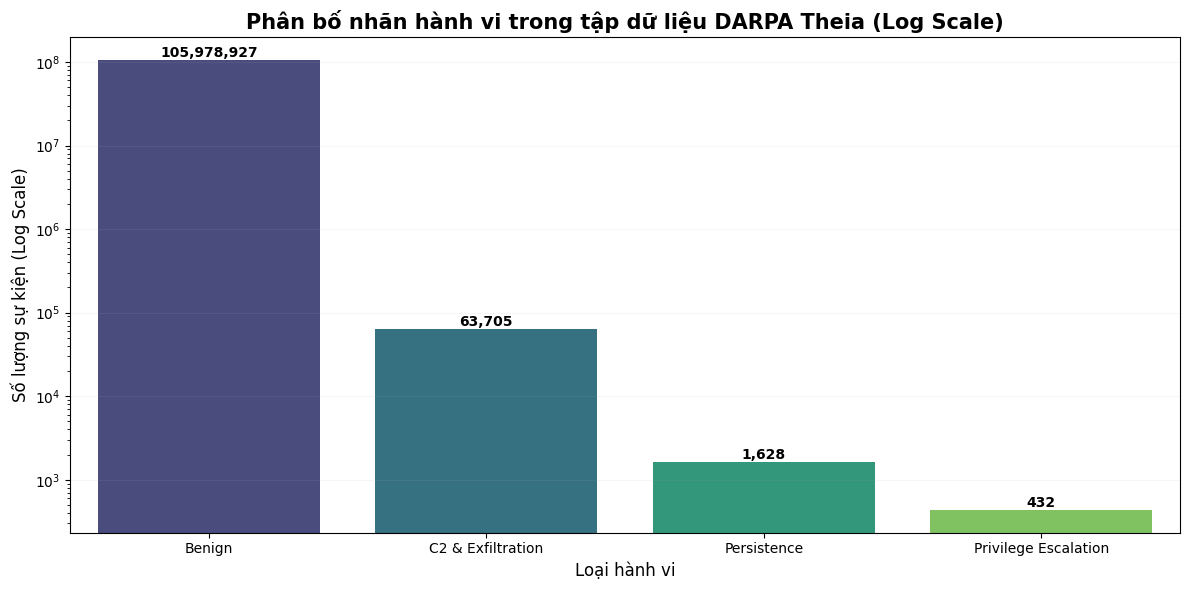

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Số liệu thực tế của bạn
data = {
    'Label': ['Benign', 'C2 & Exfiltration', 'Persistence', 'Privilege Escalation'],
    'Count': [105978927, 63705, 1628, 432]
}

df_viz = pd.DataFrame(data)

# Thiết lập kích thước
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ cột
# Dùng log=True để hiển thị trục Y theo cơ số log
ax = sns.barplot(x='Label', y='Count', data=df_viz, palette='viridis', hue='Label')
ax.set_yscale("log")

# Trang trí
plt.title('Phân bố nhãn hành vi trong tập dữ liệu DARPA Theia (Log Scale)', fontsize=15, fontweight='bold')
plt.ylabel('Số lượng sự kiện (Log Scale)', fontsize=12)
plt.xlabel('Loại hành vi', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.1)

# Thêm số liệu trên đầu cột
for i, v in enumerate(df_viz['Count']):
    ax.text(i, v, f"{v:,}", color='black', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()